# Machine Learning Optimization: 

We will use Classification Analysis to see if we can predict the type of neighborhood Tier1(Medium - High Priced House) and Tier2(Below Medium Priced Houses) based on metrics such as the diversity of restaurant categories, the location, the number of reviews, number of ratings, yelp pricing levels etc. 

Understanding the type of neighborhood can help restaurants figure out where their restaurants will be successful. It also helps them in pricing decisions as higher priced house demographic have higher disposable income. 

We will use classificaton algorithms, a type of supervised machine learning that uses labelled data to predict the likelihood that subsequent data will fall into one of the predetermined categories. 

#### Machine Learning Models
We will use five machine learning models to determine which can give the an accurate result. 

1. Logistic Regression 
2. Random Forest
3. Adaboost
4. Gradient Boost
5. Naive Bayes

#### Feature Engineering 
**Part I**

Part I of Feature Engineering was done separately in the following notebooks using the ETL(Extract, Transform, Load) technique.
1. Yelp and Housing data 
    - Housing data from zillow and redfin were cleaned and merged to extract 2021 housing price per zipcode. 
    **Notebooks**: Redfin_Cleaning_Zillow_Merge.ipynb, Zillow_Cleaning.ipynb
    - Yelp data was pulled for 6014 zipcodes through Yelp Fusion API, cleaned, and transformed to show 211 restaurant categories, pricing, yelp star rating and yelp reviews per zip code. The data was then merged with housing data. 
    **Notebooks**: Restaurant_data_merge_and_clean.ipynb, Yelp_zipcode_api_pull.ipynb, Final_Yelp_API_Data_Corrected_Clean.ipynb
    
2. Neighborhood Tiers
    - Two Tiers - Tier1 and Tier2 was created by dividing each postal_code's house price by the corresponding State's mean house price. This gives us a multiplier for each house price in the dataframe which was used to create the tiers. 

**Part II**

To optimize the model we will create the feature set with the following features. The rationale behind this approach is because we saw when we ran the random forest classifier in the previous, that these features were given the highest importance

* Drop counties that have less than 10 zipcodes

**Feature Selection**
* total_restaurants
* total_reviews
* num_rest_categories
* all the stars ratio: 
    - ratio_stars_1.0
    - ratio_stars_1.5
    - ratio_stars_2.0
    - ratio_stars_2.5
    - ratio_stars_3.0
    - ratio_stars_3.5
    - ratio_stars_4.0
    - ratio_stars_4.5
    - ratio_stars_5.0'

**Part III**

Using Standard Scalar, we will scale the model and transform the data in such a manner that it has mean as 0 and standard deviation as 1. 

The data is now ready to run the models. 

#### Model Evaluation 
We will select the best model for our prediction based on the following metrics. 

**Confusion Matrix**
A confusion matrix is a summary of prediction results on a classification problem. The number of correct and incorrect predictions are summarized with count values and broken down by each class. 
- True Positives (TP) - # correctly predicted event values.
- True Negatives (TN) - # correctly predicted no-event values.
- False Positive (FP) - # for incorrectly predicted event values.
- False Negative (FN) - # incorrectly predicted no-event values.

**Classification Report**
The classification report shows a representation of the main classification metrics on a per-class basis. This gives a deeper intuition of the classifier behavior over global accuracy which can mask functional weaknesses in one class of a multiclass problem.

The four metrics are:

* Precision = TP / (TP + FP) : measures how accurate the predictions are
* Recall = TP / (TP + FN) : % of positives correctly identified
* F1-score = 2 x (precision x recall)/(precision + recall): Harmonic mean of precision and recall.
* Accuracy - (TP + TN)/ (TP + FN + TN + FP) : tells us how often we can expect our machine learning model will correctly predict an outcome out of the total number of times it made predictions.


**Feature Importance**
Feature Importance refers to techniques that calculate a score for all the input features for a given model — the scores simply represent the “importance” of each feature. A higher score means that the specific feature will have a larger effect on the model that is being used to predict a certain variable.

In [1]:
#import dependencies
import numpy as np
import pandas as pd

from collections import Counter
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import EasyEnsembleClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB


from sklearn.pipeline import Pipeline
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)


from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, f1_score, classification_report
from sklearn.metrics import *

In [2]:
#Read in the CSV and read in the data
df = pd.read_csv("neighborhood_2tiers_state_stars_categories.csv")

In [3]:
df.head()

,postal_code,City,State,CountyName,2021,total_restaurants,total_reviews,avg_rating,total_delivery,total_pickup,total_rest_reservation,total_price_1,total_price_2,total_price_3,total_price_4,total_0.0_stars,total_1.0_stars,total_1.5_stars,total_2.0_stars,total_2.5_stars,total_3.0_stars,total_3.5_stars,total_4.0_stars,total_4.5_stars,total_5.0_stars,num_rest_types,bars_stars,newamerican_stars,wine_bars_stars,italian_stars,tapasmallplates_stars,pizza_stars,breakfast_brunch_stars,mexican_stars,mediterranean_stars,sandwiches_stars,pubs_stars,breweries_stars,cajun_stars,seafood_stars,desserts_stars,cafes_stars,venezuelan_stars,coffee_stars,comfortfood_stars,tradamerican_stars,cocktailbars_stars,bagels_stars,salad_stars,burgers_stars,korean_stars,chicken_wings_stars,french_stars,fishnchips_stars,asianfusion_stars,ramen_stars,hotdogs_stars,filipino_stars,beerbar_stars,irish_stars,mideastern_stars,japanese_stars,thai_stars,chinese_stars,vietnamese_stars,bbq_stars,gastropubs_stars,noodles_stars,sushi_stars,himalayan_stars,indpak_stars,chickenshop_stars,australian_stars,brazilian_stars,japacurry_stars,brewpubs_stars,hotdog_stars,tex-mex_stars,conveyorsushi_stars,sportsbars_stars,modern_european_stars,georgian_stars,vegan_stars,southern_stars,turkish_stars,kebab_stars,steak_stars,scandinavian_stars,colombian_stars,juicebars_stars,cupcakes_stars,caribbean_stars,creperies_stars,falafel_stars,greek_stars,tacos_stars,uzbek_stars,latin_stars,bakeries_stars,hawaiian_stars,diners_stars,popuprestaurants_stars,scottish_stars,vegetarian_stars,soup_stars,kosher_stars,dimsum_stars,cantonese_stars,beergardens_stars,szechuan_stars,whiskeybars_stars,spanish_stars,portuguese_stars,southafrican_stars,hotpot_stars,puertorican_stars,tapas_stars,malaysian_stars,singaporean_stars,wraps_stars,waffles_stars,lebanese_stars,bubbletea_stars,taiwanese_stars,raw_food_stars,halal_stars,gluten_free_stars,delis_stars,cuban_stars,german_stars,argentine_stars,beer_and_wine_stars,gaybars_stars,pancakes_stars,donuts_stars,supperclubs_stars,foodtrucks_stars,poke_stars,peruvian_stars,russian_stars,british_stars,indonesian_stars,icecream_stars,pastashops_stars,shavedice_stars,gourmet_stars,cideries_stars,panasian_stars,brasseries_stars,empanadas_stars,irish_pubs_stars,polish_stars,divebars_stars,pakistani_stars,izakaya_stars,hainan_stars,ukrainian_stars,soulfood_stars,cheesesteaks_stars,newmexican_stars,persian_stars,tikibars_stars,gelato_stars,tuscan_stars,themedcafes_stars,eatertainment_stars,moroccan_stars,foodstands_stars,salvadoran_stars,dominican_stars,drivethrubars_stars,smokehouse_stars,african_stars,buffets_stars,diyfood_stars,streetvendors_stars,shanghainese_stars,tea_stars,cakeshop_stars,teppanyaki_stars,haitian_stars,afghani_stars,customcakes_stars,honduran_stars,austrian_stars,srilankan_stars,burmese_stars,wineries_stars,hkcafe_stars,mongolian_stars,fondue_stars,acaibowls_stars,ethiopian_stars,meaderies_stars,armenian_stars,pianobars_stars,cheese_stars,coffeeroasteries_stars,basque_stars,somali_stars,sicilian_stars,distilleries_stars,laotian_stars,egyptian_stars,pretzels_stars,internetcafe_stars,macarons_stars,cambodian_stars,belgian_stars,eritrean_stars,champagne_bars_stars,nicaraguan_stars,poutineries_stars,speakeasies_stars,syrian_stars,arabian_stars,polynesian_stars,catalan_stars,trinidadian_stars,hungarian_stars,calabrian_stars,czech_stars,guamanian_stars,sardinian_stars,senegalese_stars,bangladeshi_stars,bulgarian_stars,kombucha_stars,iberian_stars,piadina_stars,vermouthbars_stars,shavedsnow_stars,pubfood_stars,bistros_stars,modern_australian_stars,rotisserie_chicken_stars,slovakian_stars,bars,newamerican,wine_bars,italian,tapasmallplates,pizza,breakfast_brunch,mexican,mediterranean,sandwiches,pubs,breweries,cajun,seafood,desserts,cafes,venezuelan,coffee,comfortfood,tradamerican,cocktailbars,bagels,salad,burgers,korean,chicken_wings,french,fishnchips,asianfusion,ramen,hotdogs,filipino,beerbar,irish,mideastern,japanese,thai,chinese,vietnamese,bbq,gastropubs,

In [4]:
df.shape

(13988, 451)

# Feature Engineering

In [5]:
#Drop counties that have less than 3 zipcodes
df = df.groupby('City').filter(lambda x : len(x)>3)
df.shape

(6160, 451)

In [6]:
df["Neighborhood Tiers"].value_counts()

1    3252
2    2908
Name: Neighborhood Tiers, dtype: int64

### Create Scaled Training and Test data

In [7]:
# Create the features
X = df[['total_restaurants','total_reviews','avg_rating','total_delivery','total_pickup','total_rest_reservation',
        'total_price_1','total_price_2','total_price_3','total_price_4','total_0.0_stars','total_1.0_stars',
        'total_1.5_stars','total_2.0_stars','total_2.5_stars','total_3.0_stars','total_3.5_stars','total_4.0_stars',
        'total_4.5_stars','total_5.0_stars','num_rest_types']]
X.head()

,total_restaurants,total_reviews,avg_rating,total_delivery,total_pickup,total_rest_reservation,total_price_1,total_price_2,total_price_3,total_price_4,total_0.0_stars,total_1.0_stars,total_1.5_stars,total_2.0_stars,total_2.5_stars,total_3.0_stars,total_3.5_stars,total_4.0_stars,total_4.5_stars,total_5.0_stars,num_rest_types
3,1,1.0,5.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,3
4,1,1.0,2.000000,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1
6,13,40.0,3.500000,0.0,0.0,0.0,2.0,3.0,1.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,5.0,2.0,1.0,9
7,19,82.0,3.736842,0.0,0.0,0.0,5.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,3.0,1.0,10.0,3.0,0.0,19
8,12,81.0,4.000000,0.0,0.0,0.0,3.0,6.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,5.0,3.0,1.0,11


In [8]:
X.describe()

,total_restaurants,total_reviews,avg_rating,total_delivery,total_pickup,total_rest_reservation,total_price_1,total_price_2,total_price_3,total_price_4,total_0.0_stars,total_1.0_stars,total_1.5_stars,total_2.0_stars,total_2.5_stars,total_3.0_stars,total_3.5_stars,total_4.0_stars,total_4.5_stars,total_5.0_stars,num_rest_types
count,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000,6160.000000
mean,26.696591,4147.603571,3.798441,18.726136,10.448052,0.299675,7.809903,10.774188,0.743669,0.147565,0.006818,0.444643,0.547403,0.989286,1.425325,2.385552,4.781494,8.218506,5.812338,2.085227,23.067208
std,28.687628,10285.228754,0.524923,23.916423,16.005455,1.056820,9.298206,14.240237,2.160632,0.753502,0.082297,1.053460,1.244710,1.917324,2.519470,3.438682,6.035371,10.792346,7.564938,2.572232,17.688783
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,5.000000,99.000000,3.500000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,0.000000,8.000000
50%,17.000000,832.500000,3.858114,10.000000,4.000000,0.000000,5.000000,5.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,4.000000,3.000000,1.000000,20.000000
75%,39.000000,3592.000000,4.123196,29.000000,14.000000,0.000000,11.000000,15.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,3.000000,7.000000,11.000000,8.000000,3.000000,35.000000
max,230.000000,272071.000000,5.000000,189.000000,163.000000,19.000000,72.000000,110.000000,37.000000,29.000000,1.000000,11.000000,18.000000,20.000000,22.000000,30.000000,51.000000,105.000000,90.000000,29.000000,96.000000


In [9]:
#Create target variable
y = df['Neighborhood Tiers']
y.head()

3    1
4    2
6    1
7    2
8    1
Name: Neighborhood Tiers, dtype: int64

In [10]:
# Splitting into Train and Test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=7)
print(f"y_train: {Counter(y_train)}")
print(f"y_test: {Counter(y_test)}")


y_train: Counter({1: 2442, 2: 2178})
y_test: Counter({1: 810, 2: 730})


In [11]:
# Creating StandardScaler instance
scaler = StandardScaler()

# Fitting Standard Scaler
X_scaler = scaler.fit(X_train)

# Scaling data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [12]:
X_train_scaled[:, 2]

array([ 0.61448536, -0.94983293,  1.3406278 , ..., -0.32949982,
        0.38626916, -0.56808948])

In [13]:
X_test_scaled[:,2]

array([ 0.72310162, -0.22724711,  0.49230901, ...,  0.27174613,
       -0.31359384, -0.88620902])

# Create a logistic regression model

In [14]:
# hyperparameters that can be tuned
LogisticRegression().get_params().keys()

dict_keys(['C', 'class_weight', 'dual', 'fit_intercept', 'intercept_scaling', 'l1_ratio', 'max_iter', 'multi_class', 'n_jobs', 'penalty', 'random_state', 'solver', 'tol', 'verbose', 'warm_start'])

In [15]:
#Define parameters for Random Forest model
LR = LogisticRegression()

#Logistic Regression
param_LR = {}
param_LR['classifier__C'] = [10**-2, 10**-1, 10**0, 10**1, 10**2]
param_LR['classifier__penalty'] = ['l1', 'l2']
param_LR['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param_LR['classifier'] = [LR]

pipeline = Pipeline([('classifier', LR)])

In [16]:
# Train the grid search model
gs_LR = GridSearchCV(pipeline,
                      param_grid=param_LR,
                      scoring='accuracy',
                      cv=3)
gs_LR.fit(X_train_scaled, y_train)
LR_best_params = gs_LR.best_params_
LR_best_params

/Users/ramyaramamurthy/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
105 fits failed out of a total of 120.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
60 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ramyaramamurthy/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ramyaramamurthy/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/ramyaramamurthy/opt/anaconda3/envs/mlenv/li

{'classifier': LogisticRegression(C=0.01),
 'classifier__C': 0.01,
 'classifier__class_weight': None,
 'classifier__penalty': 'l2'}

In [17]:
# Logistic Regression
model_LR = LogisticRegression(solver='lbfgs',C=.01, class_weight=None,
                                   random_state=1, max_iter = 200)
model_LR

LogisticRegression(C=0.01, max_iter=200, random_state=1)

In [18]:
# Train the data
model_LR.fit(X_train_scaled, y_train)

LogisticRegression(C=0.01, max_iter=200, random_state=1)

In [19]:
# Predict outcomes for test data set
y_pred_LR = model_LR.predict(X_test_scaled)
pd.DataFrame({"Prediction": y_pred_LR, "Actual": y_test}).head(20)

,Prediction,Actual
4409,1,2
7557,2,1
2432,1,2
10617,2,1
2506,2,2
12611,1,1
12408,1,1
2008,2,2
10332,2,1
7882,1,2


In [20]:
# Test data performance
print("Test Precision:",precision_score(model_LR.predict(X_test_scaled), y_test))
print("Test Recall:",recall_score(model_LR.predict(X_test_scaled), y_test))
print("Test ROC AUC Score:",roc_auc_score(model_LR.predict(X_test_scaled), y_test))
print("Test Accuracy Score:", accuracy_score(y_test, y_pred_LR))

Test Precision: 0.6172839506172839
Test Recall: 0.6934812760055479
Test ROC AUC Score: 0.6574854487475847
Test Accuracy Score: 0.6551948051948052


In [21]:
#calculate Mean Squared Error
mse_LR = mean_squared_error(y_test, y_pred_LR)
mse_LR

0.3448051948051948

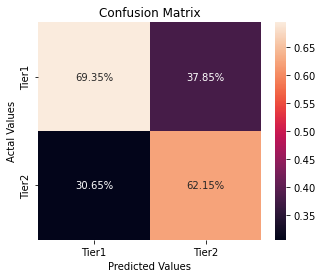

In [22]:
# Display the confusion matrix
cm_LR = confusion_matrix(y_test, y_pred_LR)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df_LR = pd.DataFrame(cm_LR,
                     index = ['Tier1','Tier2'], 
                     columns = ['Tier1','Tier2'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
#sns.heatmap(cm_df_LR, annot=True)
sns.heatmap(cm_df_LR/np.sum(cm_df_LR), annot=True, 
            fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [23]:
# Print the classification report
print(classification_report(y_test, y_pred_LR))

              precision    recall  f1-score   support

           1       0.69      0.62      0.65       810
           2       0.62      0.70      0.66       730

    accuracy                           0.66      1540
   macro avg       0.66      0.66      0.66      1540
weighted avg       0.66      0.66      0.66      1540



# Create Balanced Random Forest Classifier

### GridSearchCV

GridSearchCV is a cross-validation techniques to perform hyperparameter tuning to determine the optimal values for a machine learning model.

Hyperparameters of Random Forest Classifier
* n_estimators: number of trees in the forest
* criterion: measures the quality of the split by looking at impurity either through gini or entropy
* max_depth: maximum number of levels of a tree
* max_features: maximum number of features to consider for splitting a node

In [24]:
# hyperparameters that can be tuned
RandomForestClassifier().get_params().keys()

dict_keys(['bootstrap', 'ccp_alpha', 'class_weight', 'criterion', 'max_depth', 'max_features', 'max_leaf_nodes', 'max_samples', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_jobs', 'oob_score', 'random_state', 'verbose', 'warm_start'])

In [25]:
#Define parameters for Random Forest model
RF = RandomForestClassifier()

#Random Forest
param_RF = {}
param_RF['classifier__n_estimators'] = [10, 50, 100, 250]
param_RF['classifier__max_depth'] = [5, 10, 20]
param_RF['classifier__class_weight'] = [None, {0:1,1:5}, {0:1,1:10}, {0:1,1:25}]
param_RF['classifier__max_features'] = ['auto', 'sqrt', 'log2']
param_RF['classifier'] = [RF]
pipeline = Pipeline([('classifier', RF)])

In [26]:
# Train the grid search model
gs_RF = GridSearchCV(pipeline,
                      param_grid=param_RF,
                      scoring='accuracy',
                      cv=3)
gs_RF.fit(X_train_scaled, y_train)
RF_best_params = gs_RF.best_params_
RF_best_params

/Users/ramyaramamurthy/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
324 fits failed out of a total of 432.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
324 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/ramyaramamurthy/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/ramyaramamurthy/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/ramyaramamurthy/opt/anaconda3/envs/mlenv/l

{'classifier': RandomForestClassifier(max_depth=10, n_estimators=50),
 'classifier__class_weight': None,
 'classifier__max_depth': 10,
 'classifier__max_features': 'auto',
 'classifier__n_estimators': 50}

In [27]:
model_RF = RandomForestClassifier(n_estimators=50, criterion = 'entropy', max_depth=10, max_features='auto',
                                          class_weight = None, oob_score = True,
                                          random_state=1) 
model_RF.fit(X_train_scaled, y_train)

RandomForestClassifier(criterion='entropy', max_depth=10, n_estimators=50,
                       oob_score=True, random_state=1)

In [28]:
# Calculated the balanced accuracy score
y_pred_RF = model_RF.predict(X_test_scaled)

ROC is a probability curve and AUC represents the degree or measure of separability. It tells how much the model is capable of distinguishing between classes. Higher the AUC, the better the model is at predicting 0 classes as 0 and 1 classes as 1.

In [29]:
# Test data performance
print("Test Precision:",precision_score(model_RF.predict(X_test_scaled), y_test))
print("Test Recall:",recall_score(model_RF.predict(X_test_scaled), y_test))
print("Test ROC AUC Score:",roc_auc_score(model_RF.predict(X_test_scaled), y_test))
print("Test Accuracy Score:", accuracy_score(y_test, y_pred_RF))

Test Precision: 0.7320987654320987
Test Recall: 0.6761687571265679
Test ROC AUC Score: 0.6744343031485026
Test Accuracy Score: 0.6746753246753247


In [30]:
oob_RF = model_RF.oob_score_
oob_error = 1-oob_RF
print("The oob score is:", oob_RF)
print("The oob error is:", oob_error)

The oob score is: 0.674025974025974
The oob error is: 0.325974025974026


In [31]:
#calculate Mean Squared Error
mse_RF = mean_squared_error(y_test, y_pred_RF)
mse_RF

0.32532467532467535

In [118]:
pd.DataFrame({"Prediction": y_pred_RF, "Actual": y_test}).head(20)

,Prediction,Actual
4409,1,2
7557,2,1
2432,1,2
10617,2,1
2506,2,2
12611,1,1
12408,1,1
2008,2,2
10332,2,1
7882,1,2


In [33]:
# Calculate feature importance in the Random Forest model.
importances = model_RF.feature_importances_
importances

array([0.05581211, 0.15918431, 0.06495191, 0.06164015, 0.07341147,
       0.01267939, 0.07859016, 0.09298721, 0.02615093, 0.00811191,
       0.00065214, 0.01877943, 0.02050999, 0.01910431, 0.0272633 ,
       0.02938625, 0.03517529, 0.04701238, 0.05118404, 0.04864361,
       0.06876972])

In [34]:
# We can sort the features by their importance.
sorted(zip(model_RF.feature_importances_, X.columns), reverse=True)


[(0.15918430850111362, 'total_reviews'),
 (0.09298720868425077, 'total_price_2'),
 (0.07859015553225415, 'total_price_1'),
 (0.07341147163682099, 'total_pickup'),
 (0.06876971728160824, 'num_rest_types'),
 (0.06495190501448946, 'avg_rating'),
 (0.061640151697409294, 'total_delivery'),
 (0.05581211008614637, 'total_restaurants'),
 (0.05118404491346795, 'total_4.5_stars'),
 (0.04864361264720633, 'total_5.0_stars'),
 (0.047012381877399846, 'total_4.0_stars'),
 (0.03517529455194963, 'total_3.5_stars'),
 (0.029386251392047456, 'total_3.0_stars'),
 (0.02726329789524191, 'total_2.5_stars'),
 (0.026150928762220298, 'total_price_3'),
 (0.020509987952409738, 'total_1.5_stars'),
 (0.019104308415352298, 'total_2.0_stars'),
 (0.01877942735079246, 'total_1.0_stars'),
 (0.012679393861406608, 'total_rest_reservation'),
 (0.008111906891870883, 'total_price_4'),
 (0.000652135054541846, 'total_0.0_stars')]

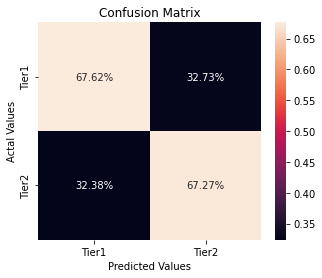

In [36]:
# Display the confusion matrix
cm_RF = confusion_matrix(y_test, y_pred_RF)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df_RF = pd.DataFrame(cm_RF,
                     index = ['Tier1','Tier2'], 
                     columns = ['Tier1','Tier2'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_RF/np.sum(cm_df_RF), annot=True, fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [37]:
# Print the classification report
print(classification_report(y_test, y_pred_RF))

              precision    recall  f1-score   support

           1       0.68      0.73      0.70       810
           2       0.67      0.61      0.64       730

    accuracy                           0.67      1540
   macro avg       0.67      0.67      0.67      1540
weighted avg       0.67      0.67      0.67      1540



# Create Easy Ensemble AdaBoost Classifier

In [38]:
# hyperparameters that can be tuned
EasyEnsembleClassifier().get_params().keys()

dict_keys(['base_estimator', 'n_estimators', 'n_jobs', 'random_state', 'replacement', 'sampling_strategy', 'verbose', 'warm_start'])

In [39]:
#Define parameters for Random Forest model
ADA = EasyEnsembleClassifier()

#Ada Boost
param_ADA = {}
param_ADA['classifier__n_estimators'] = [10, 50, 100, 250]
param_ADA['classifier'] = [ADA]
pipeline = Pipeline([('classifier', ADA)])

In [40]:
# Train the grid search model
gs_ADA = GridSearchCV(pipeline,
                      param_grid=param_ADA,
                      scoring='accuracy',
                      cv=3)
gs_ADA.fit(X_train_scaled, y_train)
ADA_best_params = gs_ADA.best_params_
ADA_best_params

{'classifier': EasyEnsembleClassifier(n_estimators=50),
 'classifier__n_estimators': 50}

In [41]:
# Train the EasyEnsembleClassifier
model_Ada = EasyEnsembleClassifier(n_estimators=10, random_state=1) 
model_Ada.fit(X_train_scaled, y_train)

EasyEnsembleClassifier(random_state=1)

In [45]:
# Calculated the balanced accuracy score
y_pred_Ada = model_Ada.predict(X_test_scaled)

In [46]:
# Test data performance
print("Test Precision:",precision_score(model_Ada.predict(X_test_scaled), y_test))
print("Test Recall:",recall_score(model_Ada.predict(X_test_scaled), y_test))
print("Test ROC AUC Score:",roc_auc_score(model_Ada.predict(X_test_scaled), y_test))
print("Test Accuracy Score:", accuracy_score(y_test, y_pred_Ada))

Test Precision: 0.6382716049382716
Test Recall: 0.6865869853917662
Test ROC AUC Score: 0.6571435562282847
Test Accuracy Score: 0.6564935064935065


In [47]:
pd.DataFrame({"Prediction": y_pred_Ada, "Actual": y_test}).head(10)

,Prediction,Actual
4409,1,2
7557,2,1
2432,1,2
10617,2,1
2506,2,2
12611,1,1
12408,1,1
2008,2,2
10332,2,1
7882,1,2


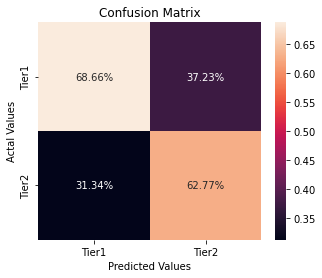

In [48]:
# Display the confusion matrix
cm_Ada = confusion_matrix(y_test, y_pred_Ada)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df_Ada = pd.DataFrame(cm_Ada,
                     index = ['Tier1','Tier2'], 
                     columns = ['Tier1','Tier2'])
#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_Ada/np.sum(cm_df_Ada), annot=True, 
            fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [49]:
# Print the imbalanced classification report
print(classification_report(y_test, y_pred_Ada))

              precision    recall  f1-score   support

           1       0.69      0.64      0.66       810
           2       0.63      0.68      0.65       730

    accuracy                           0.66      1540
   macro avg       0.66      0.66      0.66      1540
weighted avg       0.66      0.66      0.66      1540



# Create Gradient Boosting Classifier

In [50]:
# hyperparameters that can be tuned
GradientBoostingClassifier().get_params().keys()

dict_keys(['ccp_alpha', 'criterion', 'init', 'learning_rate', 'loss', 'max_depth', 'max_features', 'max_leaf_nodes', 'min_impurity_decrease', 'min_samples_leaf', 'min_samples_split', 'min_weight_fraction_leaf', 'n_estimators', 'n_iter_no_change', 'random_state', 'subsample', 'tol', 'validation_fraction', 'verbose', 'warm_start'])

In [51]:
#Define parameters for Gradient Boosting Classifier
GB = GradientBoostingClassifier()

#Gradient Boost
param_GB = {}
param_GB['classifier__n_estimators'] = [10, 50, 100, 250]
param_GB['classifier__max_depth'] = [5, 10, 20]
param_GB['classifier'] = [GB]
pipeline = Pipeline([('classifier', GB)])

In [52]:
# Train the grid search model
gs_GB = GridSearchCV(pipeline,
                      param_grid=param_GB,
                      scoring='accuracy',
                      cv=3)
gs_GB.fit(X_train_scaled, y_train)
GB_best_params = gs_GB.best_params_
GB_best_params

{'classifier': GradientBoostingClassifier(max_depth=5, n_estimators=50),
 'classifier__max_depth': 5,
 'classifier__n_estimators': 50}

In [53]:
# Create a classifier object
learning_rates = [0.05, 0.1, 0.25, 0.5, 0.75, 1]
for learning_rate in learning_rates:
    classifier_GBC = GradientBoostingClassifier(n_estimators=50,
                                            learning_rate=learning_rate,
                                            max_features='auto',
                                            max_depth=5,
                                            random_state=1)
    # Fit the model
    classifier_GBC.fit(X_train_scaled, y_train)
    print("Learning rate: ", learning_rate)

    # Score the model
    print("Accuracy score (training): {0:.3f}".format(
        classifier_GBC.score(
            X_train_scaled,
            y_train)))
    print("Accuracy score (validation): {0:.3f}".format(
        classifier_GBC.score(
            X_test_scaled,
            y_test)))
    print()

Learning rate:  0.05
Accuracy score (training): 0.744
Accuracy score (validation): 0.669

Learning rate:  0.1
Accuracy score (training): 0.764
Accuracy score (validation): 0.669

Learning rate:  0.25
Accuracy score (training): 0.834
Accuracy score (validation): 0.651

Learning rate:  0.5
Accuracy score (training): 0.885
Accuracy score (validation): 0.634

Learning rate:  0.75
Accuracy score (training): 0.920
Accuracy score (validation): 0.614

Learning rate:  1
Accuracy score (training): 0.929
Accuracy score (validation): 0.601



In [54]:
# Make Prediction
y_pred_GBC = classifier_GBC.predict(X_test_scaled)
pd.DataFrame({"Prediction": y_pred_GBC, "Actual": y_test}).head(20)

,Prediction,Actual
4409,2,2
7557,1,1
2432,1,2
10617,2,1
2506,2,2
12611,1,1
12408,1,1
2008,2,2
10332,1,1
7882,1,2


In [55]:
# Test data performance
print("Test Precision:",precision_score(classifier_GBC.predict(X_test_scaled), y_test))
print("Test Recall:",recall_score(classifier_GBC.predict(X_test_scaled), y_test))
print("Test ROC AUC Score:",roc_auc_score(classifier_GBC.predict(X_test_scaled), y_test))
print("Test Accuracy Score:", accuracy_score(y_test, y_pred_GBC))

Test Precision: 0.6469135802469136
Test Recall: 0.6150234741784038
Test ROC AUC Score: 0.5996628998798995
Test Accuracy Score: 0.6012987012987013


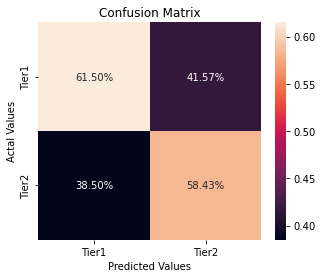

In [56]:
cm_GBC = confusion_matrix(y_test, y_pred_GBC)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df_GBC = pd.DataFrame(cm_GBC,
                     index = ['Tier1','Tier2'], 
                     columns = ['Tier1','Tier2'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_GBC/np.sum(cm_df_GBC), annot=True, 
            fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [57]:
# Print the imbalanced classification report
print(classification_report(y_test, y_pred_GBC))


              precision    recall  f1-score   support

           1       0.62      0.65      0.63       810
           2       0.58      0.55      0.57       730

    accuracy                           0.60      1540
   macro avg       0.60      0.60      0.60      1540
weighted avg       0.60      0.60      0.60      1540



# Naive Bayes model

In [58]:
# hyperparameters that can be tuned
GaussianNB().get_params().keys()

dict_keys(['priors', 'var_smoothing'])

In [59]:
from sklearn.naive_bayes import GaussianNB
classifiers_bayes = GaussianNB()
classifiers_bayes.fit(X_train_scaled, y_train)

GaussianNB()

In [60]:
y_pred_bayes  =  classifiers_bayes.predict(X_test_scaled)

In [61]:
pd.DataFrame({"Prediction": y_pred_bayes, "Actual": y_test}).head(20)

,Prediction,Actual
4409,1,2
7557,2,1
2432,2,2
10617,2,1
2506,1,2
12611,1,1
12408,2,1
2008,2,2
10332,2,1
7882,2,2


In [62]:
# Calculating the accuracy score
acc_score_bayes = accuracy_score(y_test, y_pred_bayes)
print(f"Accuracy Score : {acc_score_bayes}")

Accuracy Score : 0.5701298701298702


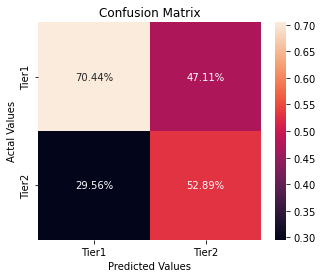

In [63]:
cm_bayes = confusion_matrix(y_test, y_pred_bayes)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df_bayes = pd.DataFrame(cm_bayes,
                     index = ['Tier1','Tier2'], 
                     columns = ['Tier1','Tier2'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_bayes/np.sum(cm_df_bayes), annot=True, 
            fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

In [64]:
# Print the imbalanced classification report
print(classification_report(y_test, y_pred_bayes))

              precision    recall  f1-score   support

           1       0.70      0.31      0.44       810
           2       0.53      0.85      0.65       730

    accuracy                           0.57      1540
   macro avg       0.62      0.58      0.54      1540
weighted avg       0.62      0.57      0.54      1540



# Model Comparison

#### Model Metrics

* Accuracy - (TP + TN)/ (TP + FN + TN + FP)

Accuracy score is used to measure the model performance in terms of measuring the ratio of sum of true positive and true negatives out of all the predictions made.

* F1-score = 2 x (precision x recall)/(precision + recall)

F1-score is harmonic mean of precision and recall score and is used as a metrics in the scenarios where choosing either of precision or recall score can result in compromise in terms of model giving high false positives and false negatives respectively. An F1 score is considered perfect when it's 1, while the model is a total failure when it's 0.

* Recall = TP / (TP + FN) :

Recall score is used to measure the model performance in terms of measuring the count of true positives in correct manner out of all the actual positive values.
Precision-Recall score is a useful measure of success of prediction when the classes are very imbalanced. 

* Precision = TP / (TP + FP) :

Precision score is used to measure the model performance on measuring the count of true positives in correct manner out of all positive predictions made.

#### Calculate Model Metrics for all 5 models for comparison

In [83]:
#Accuracy Scores of all models

accuracy_NB = (accuracy_score(y_test, y_pred_bayes)*100).round(2).astype(str) + '%'
accuracy_RF = (accuracy_score(y_test, y_pred_RF)*100).round(2).astype(str) + '%'
accuracy_ADA = (accuracy_score(y_test, y_pred_Ada)*100).round(2).astype(str) + '%'
accuracy_GBC = (accuracy_score(y_test, y_pred_GBC)*100).round(2).astype(str) + '%'
accuracy_LR = (accuracy_score(y_test, y_pred_LR)*100).round(2).astype(str) + '%'

# f1 scores for all models
f1_NB = (f1_score(y_test, y_pred_bayes, average='weighted')*100).round(2).astype(str) + '%'
f1_RF = (f1_score(y_test, y_pred_RF, average='weighted')*100).round(2).astype(str) + '%'
f1_ADA = (f1_score(y_test, y_pred_Ada, average='weighted')*100).round(2).astype(str) + '%'
f1_GBC = (f1_score(y_test, y_pred_GBC, average='weighted')*100).round(2).astype(str) + '%'
f1_LR = (f1_score(y_test, y_pred_LR, average='weighted')*100).round(2).astype(str) + '%'

#recall scores for all models
recall_NB = (recall_score(y_test, y_pred_bayes, average='weighted')*100).round(2).astype(str) + '%'
recall_RF = (recall_score(y_test, y_pred_RF, average='weighted')*100).round(2).astype(str) + '%'
recall_ADA = (recall_score(y_test, y_pred_Ada, average='weighted')*100).round(2).astype(str) + '%'
recall_GBC = (recall_score(y_test, y_pred_GBC, average='weighted')*100).round(2).astype(str) + '%'
recall_LR = (recall_score(y_test, y_pred_LR, average='weighted')*100).round(2).astype(str) + '%'

#precision scores for all models

precision_NB = (precision_score(y_test, y_pred_bayes, average='weighted')*100).round(2).astype(str) + '%'
precision_RF = (precision_score(y_test, y_pred_RF, average='weighted')*100).round(2).astype(str) + '%'
precision_ADA = (precision_score(y_test, y_pred_Ada, average='weighted')*100).round(2).astype(str) + '%'
precision_GBC = (precision_score(y_test, y_pred_GBC, average='weighted')*100).round(2).astype(str) + '%'
precision_LR = (precision_score(y_test, y_pred_LR, average='weighted')*100).round(2).astype(str) + '%'

In [84]:
data = {'Model':['Logistic Regression', 'Random Forest', 'Ada Boost', 'Gradient Boost', 'Naive Bayes'],
        'Accuracy':[accuracy_LR, accuracy_RF, accuracy_ADA, accuracy_GBC, accuracy_NB],
       'F1 Score': [f1_LR, f1_RF, f1_ADA, f1_GBC, f1_NB],
       'Recall': [recall_LR, recall_RF, recall_ADA, recall_GBC, recall_NB],
       'Precision': [precision_LR, precision_RF, precision_ADA, precision_GBC, precision_NB]}
metric_df = pd.DataFrame(data)
metric_df = metric_df.set_index('Model')
metric_df

,Accuracy,F1 Score,Recall,Precision
Model,,,,
Logistic Regression,65.52%,65.51%,65.52%,65.94%
Random Forest,67.47%,67.33%,67.47%,67.45%
Ada Boost,65.65%,65.67%,65.65%,65.87%
Gradient Boost,60.13%,60.04%,60.13%,60.05%
Naive Bayes,57.01%,53.84%,57.01%,62.12%


Random Forest Model with 67.47% accuracy score and 67.33% F1 score perfoms the better than the other models. 

# Random Forest Model Evaluation

Now that we know that Random Forest Classifier is th best model for the data, we need to evaluate the model to see if it's predictions are actually useful. 

#### Plot feature importance

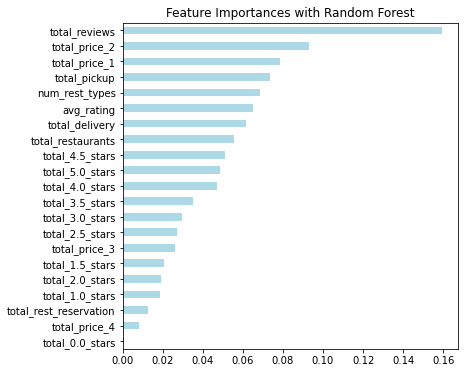

In [86]:
# Plot influential features based on Random Forest model:
influential_features = pd.Series(model_RF.feature_importances_, X.columns)
influential_features.nlargest(25).sort_values().plot(kind='barh', color='lightblue', figsize=(6,6))
plt.title('Feature Importances with Random Forest');


#### Confusion Matrix for Random Forest Classifier

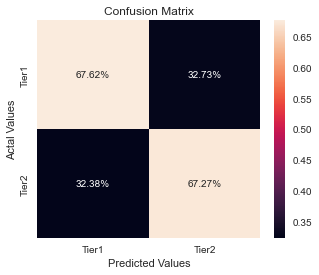

In [143]:
# Display the confusion matrix
cm_RF = confusion_matrix(y_test, y_pred_RF)
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df_RF = pd.DataFrame(cm_RF,
                     index = ['Tier1','Tier2'], 
                     columns = ['Tier1','Tier2'])

#Plotting the confusion matrix
plt.figure(figsize=(5,4))
sns.heatmap(cm_df_RF/np.sum(cm_df_RF), annot=True, fmt='.2%')
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()

Approximately 67% of True Positives and True Negatives are predicted accurately by the model.

### Baseline: for evaluation of Random Forest model accuracy

We've seen that the Random Forest Classifier is a good model for this data. *But, is our  model really better than just guessing?*

We need a baseline for this. A baseline is a reference from which you can compare algorithms. 

Reading: [Why we need a baseline](https://medium.com/@limavallantin/why-you-should-not-trust-only-in-accuracy-to-measure-machine-learning-performance-a72cf00b4516)

Lets call this a "trivial classifier" - TC. Meaning, let's simply predict everything as one of the Tiers. 
Lets create a baseline for our model

In our test set we have 
* Tier1: 810
* Tier2: 730
There is almost a 50-50 split because we have class-balanced data set.

We will predict everything as Tier1 (the larger value).
Any model that shows a better performance than our trivial classifier shows that the selecetde independent features aid in the prediction process. 

Lets calculate the metrics : accuracy, precison, recall and f1 score for the Trivial Classifier (baseline model)

In [127]:
y_pred_TC = np.copy(y_test)
y_pred_TC[:] = 1
len(y_pred_TC)
cm_TC= confusion_matrix(y_test, y_pred_LR)

In [134]:
accuracy_TC = (accuracy_score(y_test, y_pred_TC)*100).round(2).astype(str) + '%'
f1_TC = (f1_score(y_test, y_pred_TC, average='weighted')*100).round(2).astype(str) + '%'
recall_TC = (recall_score(y_test, y_pred_TC, average='weighted')*100).round(2).astype(str) + '%'
precision_TC = (precision_score(y_test, y_pred_TC, average='weighted')*100).round(2).astype(str) + '%'

/Users/ramyaramamurthy/opt/anaconda3/envs/mlenv/lib/python3.7/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [135]:
data_baseline = {'Model':['Random Forest', 'Trivial Classifier'],
        'Accuracy':[ accuracy_RF, accuracy_TC],
       'F1 Score': [f1_RF, f1_TC],
       'Recall': [recall_RF, recall_TC],
       'Precision': [precision_RF, precision_TC]}
metric_df_baseline = pd.DataFrame(data_baseline)
metric_df_baseline = metric_df_baseline.set_index('Model')
metric_df_baseline

,Accuracy,F1 Score,Recall,Precision
Model,,,,
Random Forest,67.47%,67.33%,67.47%,67.45%
Trivial Classifier,52.6%,36.26%,52.6%,27.66%


We can conclude that that the Random Forest Classifier  shows a better performance than our trivial classifier and shows that the selected independent features aid in the prediction process.

# Conclusion:

We can see that the Random Forest Classifier gives the best results with an accuracy of 67.47%% and an F1 score of 67.33%. And the most influential features driving the prediction are Total Reviews, Total Price, Average Restaurant Rating, Total Restaurants Delivery and Pickup, and Total number of Restaurant categories follow. 

Note, we are using only a sample of the Yelp data in a neighborhood. In reality, the number of restaurant categories is/can be more for a zipcode. 

Inspite of the limitations of the data, the model accuracy prediction is ~67%. So we cautiously conclude that diversity of restaurants in an area, the type of services they offer and the total reviews can predict the type of neighborhood, classified on median houseprice in the area. 

# Recommendations:*

1. We should do an analysis more granuraliy, for example, get all the restaurnts for a borough in a city, like Bronx in NYC. 
2. We should add demographic data as an additional parameter to our prediction. 

**Value of doing such an analysis:**
Understanding the type of neighborhood can help restaurants figure out where their restaurants will be successful. It also helps them in pricing decisions as higher priced house demographic have higher disposable income. 



In [145]:
data = {'Model':['Trivial Classifier (Baseline)', 'Random Forest','Logistic Regression', 'Ada Boost', 'Gradient Boost', 'Naive Bayes'],
        'Accuracy':[accuracy_TC, accuracy_RF, accuracy_LR, accuracy_ADA, accuracy_GBC, accuracy_NB],
       'F1 Score': [f1_TC, f1_RF,f1_TC, f1_ADA, f1_GBC, f1_NB],
       'Recall': [recall_TC, recall_RF,recall_TC, recall_ADA, recall_GBC, recall_NB],
       'Precision': [precision_TC, precision_RF, precision_TC, precision_ADA, precision_GBC, precision_NB]}
metric_df = pd.DataFrame(data)
metric_df = metric_df.set_index('Model')
metric_df

,Accuracy,F1 Score,Recall,Precision
Model,,,,
Trivial Classifier (Baseline),52.6%,36.26%,52.6%,27.66%
Random Forest,67.47%,67.33%,67.47%,67.45%
Logistic Regression,65.52%,36.26%,52.6%,27.66%
Ada Boost,65.65%,65.67%,65.65%,65.87%
Gradient Boost,60.13%,60.04%,60.13%,60.05%
Naive Bayes,57.01%,53.84%,57.01%,62.12%
